# ECE 271A HW \#5 The Cheetah Problem (Continued)

In [174]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
%matplotlib inline

In [2]:
m = loadmat('../data/TrainingSamplesDCT_8_new.mat')
foreground,background = m['TrainsampleDCT_FG'],m['TrainsampleDCT_BG']

In [3]:
# define the zigzag transformation
zig_zag = np.array([[0,1,5,6,14,15,27,28],[2,4,7,13,16,26,29,42],[3,8,12,17,25,30,41,43],
                   [9,11,18,24,31,40,44,53],[10,19,23,32,39,45,52,54],[20,22,33,38,46,51,55,60],
                   [21,34,37,47,50,56,59,61],[35,36,48,49,57,58,62,63]])
zz_flat = zig_zag.flatten()
def zig_zag_transform(a):
    result = np.zeros(64)
    for i in range(64):
        result[zz_flat[i]] = a[i]
    return result

In [4]:
# 2D DCT function
import scipy.fftpack
def dct2d(a):
    return scipy.fftpack.dct(scipy.fftpack.dct( a, axis=0, norm='ortho' ),axis=1,norm='ortho')

In [5]:
im = loadmat('../data/im_double.mat')
im_array = im['img']
print(im_array.shape)

(255, 270)


In [6]:
import imageio
# store the test data as a numpy array
im_test = imageio.imread('../data/cheetah_mask.bmp')
im_test_array = np.array(im_test)
# convert 255 to 1 for error calculation
im_test_array = im_test_array / 255

In [ ]:
def image_process(im_array):
    result = []
    for i in range(im_array.shape[0]-8):
        for j in range(im_array.shape[1]-8):
            row_start,row_end = i,i+8
            col_start,col_end = j,j+8
            block = im_array[row_start:row_end,col_start:col_end]
            block_dct = dct2d(block).flatten()
            block_dct= zig_zag_transform(block_dct)
            result.append(block_dct)
    result = np.array(result)
    return result

### a) 5 foreground and 5 background mixture models with 8 components:

In [7]:
M,C,N_FG,N_BG = 5,8,foreground.shape[0],background.shape[0]

In [206]:
# random initialization
def rand_init(c,sample):
    pi = np.ones(c) * 1 / c
    mu = np.random.randn(c,64)
    cov = []
    for i in range(c):
        cov_temp = np.random.normal(5,0.3,size=64)
        cov.append(np.diag(cov_temp))
    cov = np.array(cov)
    return pi,mu,cov

In [194]:
def EM(c,sample,max_iter):
    pi,mu,cov = rand_init(c,sample)
    for i in range(max_iter):
        # E-step
        H = []
        for j in range(c):
            H_temp = multivariate_normal.pdf(sample,mean=mu[j,:],cov=cov[j,:,:]) * pi[j]
            H.append(H_temp)
        H = np.array(H).T
        H = H / np.sum(H,axis = 1)[:,np.newaxis]
        H_sum = np.sum(H,axis = 0)
        # M-step
        # update pi
        pi = 1 / sample.shape[0] * H_sum
        # update mean
        mu_update = []
        for j in range(c):
            mu_temp = np.sum(H[:,j][:,np.newaxis] * sample,axis = 0) / H_sum[j]
            mu_update.append(mu_temp)
        # update covariance
        cov_update = []
        for j in range(c):
            x_temp = sample - mu[j,:]
            cov_temp = np.sum((x_temp ** 2) * H[:,j][:,np.newaxis],axis = 0) / H_sum[j]
            # make sure cov is not too small
            cov_temp[cov_temp < 1e-6] = 1e-6
            cov_temp = np.diag(cov_temp)
            cov_update.append(cov_temp)
        cov = np.array(cov_update)
        mu = np.array(mu_update)
    return pi,mu,cov

In [195]:
def Gaussian_mixture_BDR(pi_FG,mu_FG,cov_FG,pi_BG,mu_BG,cov_BG,FG,BG,im_array,dim):
    c = mu_FG.shape[0]
    im_blocks = image_process(im_array)[:,:dim]
    FG_prob,BG_prob,A = np.zeros(247*262),np.zeros(247*262),np.zeros(247*262)
    for k in range(c):
        FG_prob += multivariate_normal.pdf(im_blocks,mean = mu_FG[k],cov = cov_FG[k]) * pi_FG[k]
    for k in range(c):
        BG_prob += multivariate_normal.pdf(im_blocks,mean = mu_BG[k],cov = cov_BG[k]) * pi_BG[k]
    A = FG_prob - BG_prob
    A = np.where(A>0,1,0)
    A_matrix = np.reshape(A,(247,262))                
    A_matrix = np.lib.pad(A_matrix,(4,4),'constant',constant_values = 0)
    return A_matrix

In [196]:
def prob_error(A,B):
    return np.sum(np.absolute(A-B)) / (255*270)

In [212]:
error_dic0 = {}
dim = np.array([1,2,4,8,16,24,32,40,48,56,64])
for idx_FG in range(M):
    print('FG '+ str(idx_FG))
    pi_FG,mu_FG,cov_FG = EM(8,foreground,200)
    for idx_BG in range(M):
        print('BG '+ str(idx_BG))
        pi_BG,mu_BG,cov_BG = EM(8,background,200)
        error_list = []
        for cur_dim in dim:
            print('dimension ' + str(cur_dim))
            mu_FG_cur,cov_FG_cur = mu_FG[:,:cur_dim],cov_FG[:,:cur_dim,:cur_dim]
            mu_BG_cur,cov_BG_cur = mu_BG[:,:cur_dim],cov_BG[:,:cur_dim,:cur_dim]
            A = Gaussian_mixture_BDR(pi_FG,mu_FG_cur,cov_FG_cur,pi_BG,mu_BG_cur,
                                 cov_BG_cur,foreground,background,im_array,cur_dim)
            error = prob_error(A.flatten(),im_test_array.flatten())
            error_list.append(error)
        error_list = np.array(error_list)
        label = 'FG' + str(idx_FG) + 'BG' + str(idx_BG)
        error_dic0[label] = error_list

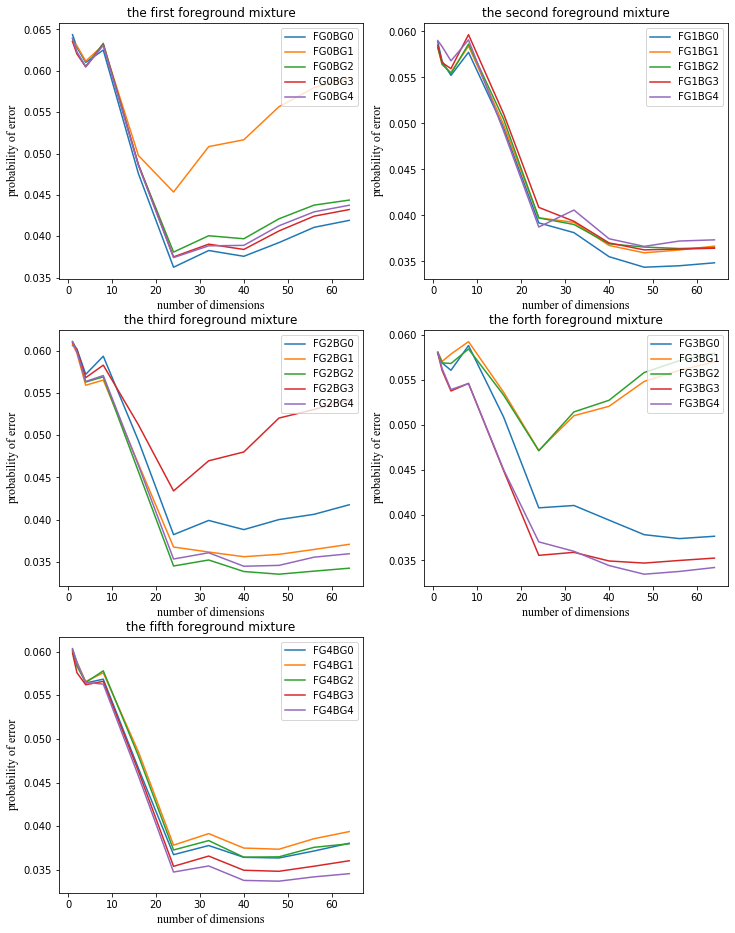

In [198]:
fig=plt.figure(figsize=(12,16))
voc = ['first','second','third','forth','fifth']
for idx_FG in range(M):
    fig.add_subplot(3,2,idx_FG+1)
    plt.plot(dim,error_dic0['FG'+str(idx_FG)+'BG0'],label = 'FG'+str(idx_FG)+'BG0')
    plt.plot(dim,error_dic0['FG'+str(idx_FG)+'BG1'],label = 'FG'+str(idx_FG)+'BG1')
    plt.plot(dim,error_dic0['FG'+str(idx_FG)+'BG2'],label = 'FG'+str(idx_FG)+'BG2')
    plt.plot(dim,error_dic0['FG'+str(idx_FG)+'BG3'],label = 'FG'+str(idx_FG)+'BG3')
    plt.plot(dim,error_dic0['FG'+str(idx_FG)+'BG4'],label = 'FG'+str(idx_FG)+'BG4')
    plt.title('the '+ voc[idx_FG] + ' foreground mixture')
    plt.legend(loc='upper right')
    plt.xlabel('number of dimensions', fontdict={'family' : 'Times New Roman', 'size'   : 12})
    plt.ylabel('probability of error', fontdict={'family' : 'Times New Roman', 'size'   : 12})

The plot of POE with respect to different number of dimensions is shown above. As we can see from the result, the combination of different foreground and background mixture models will generate different results(probability of error). This is because of the random initialization during the EM training. Also we can observe that with the increase of the number of dimensions, the difference between the results of different mixture models increases.
<br/>
<br/>
However, we can observe that the general trend of all 25 models are really similar. With more dimensions, the probablility of error generally decreases. However, as shown in homework 2, if we select the best 8 features, the result will be better than using all 64 features. As we can see from the result of this homework, for all 25 models the POE doesn't reach its minimum when we use all 64 dimensions. The number of dimensions that have the best probability of error varies within all 25 models, but generally it is betwenn 24 to 48.

### b) Mixture models with different numbers of components:

In [210]:
error_dic1 = {}
dim = np.array([1,2,4,8,16,24,32,40,48,56,64])
mixtures = np.array([1,2,4,8,16,32])
for c in mixtures:
    error_list = []
    pi_FG,mu_FG,cov_FG = EM(c,foreground,200)
    pi_BG,mu_BG,cov_BG = EM(c,background,200)
    for cur_dim in dim:
        mu_FG_cur,cov_FG_cur = mu_FG[:,:cur_dim],cov_FG[:,:cur_dim,:cur_dim]
        mu_BG_cur,cov_BG_cur = mu_BG[:,:cur_dim],cov_BG[:,:cur_dim,:cur_dim]
        A = Gaussian_mixture_BDR(pi_FG,mu_FG_cur,cov_FG_cur,pi_BG,mu_BG_cur,
                                 cov_BG_cur,foreground,background,im_array,cur_dim)
        error = prob_error(A.flatten(),im_test_array.flatten())
        error_list.append(error)
    error_list = np.array(error_list)
    label = str(c)
    error_dic1[label] = error_list

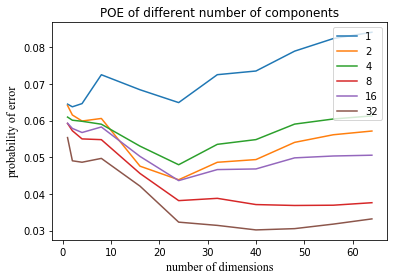

In [211]:
for i in range(mixtures.shape[0]):
    plt.plot(dim,error_dic1[str(2**(i))],label = str(2**(i)))
plt.title('POE of different number of components')
plt.legend(loc='upper right')
plt.xlabel('number of dimensions', fontdict={'family' : 'Times New Roman', 'size'   : 12})
plt.ylabel('probability of error', fontdict={'family' : 'Times New Roman', 'size'   : 12})
plt.show()

As we can see from the result, the POE of the mixture model with only 1 component is strictly larger than the results of the rest of the models. Thus we can conclude that, using only 1 component cannot best fit the true distribution of $P_{X|Y}(x|i)$, in other words $P_{X|Y}(x|i)$ is not just a simple multivariate Gaussian distribution. With more components the trend of different curves are generally the same. In this experiment, using 32 components can give us the best probability of error. However, the optimal number of components cannot be revealed from this single experiment.